Stochastic gradient descent

In [1]:
import pandas as pd #for dataframe control
import matplotlib.pyplot as plt #for plotting
import seaborn as sns #for plotting
%matplotlib inline
import numpy as np #for math
import matplotlib.image as mpimg #for digit image reconstruction
import time #to time code

Import and slightly modify data

In [2]:
df=pd.read_csv('train.csv')
df[df.iloc[:,1:]>0]=1

Create training and cross validation indices for data

In [5]:
trainIndex=np.random.choice(df.index.values,int(len(df)*.8),replace=False);
cvIndex=[num for num in df.index.values if num not in trainIndex];

Define functions for logistic regression and gradient descent.

In [6]:
def sigmoid(Theta,X):
    z=np.dot(Theta,X.transpose())
    g=1/(1+np.exp(-z));
    return g
def CostFunction(y,Theta, X):
    J=-1/len(y)*(np.dot(y,np.log(sigmoid(Theta,X)+.005))+
                 np.dot(np.subtract(np.ones(len(y)),[0])-y,np.log(1.005-sigmoid(Theta,X))));
    return J
def GradDescent(y,Theta,X,alpha):
    D=alpha*np.dot(sigmoid(Theta,X)-y,X)
    ThetaNew=Theta-D
    return ThetaNew

In new dataframe (unnecessary), add column for binary labeling

In [7]:
df2=df.copy()
df2.insert(1,'binary',0)

Add column for constant

In [8]:
df2.insert(2,'ones',1)

Testing between regular gradient descent and stochastic gradient descent. Varied num of steps and step size while keeping time of computation relatively constant.

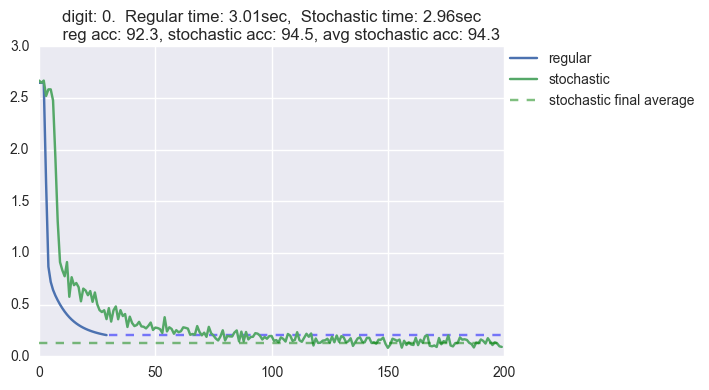

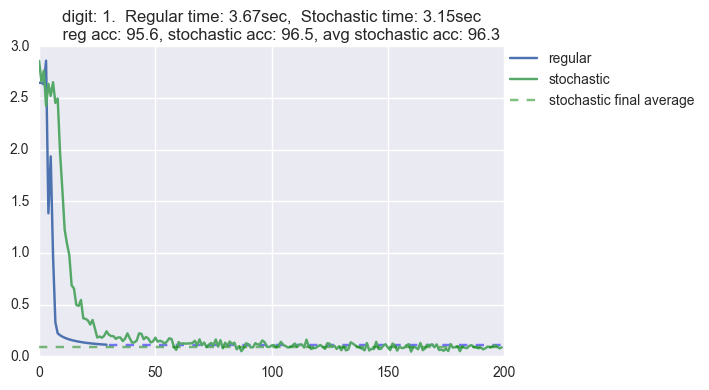

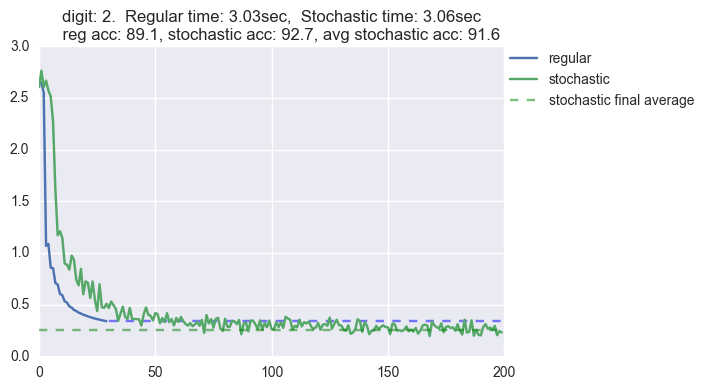

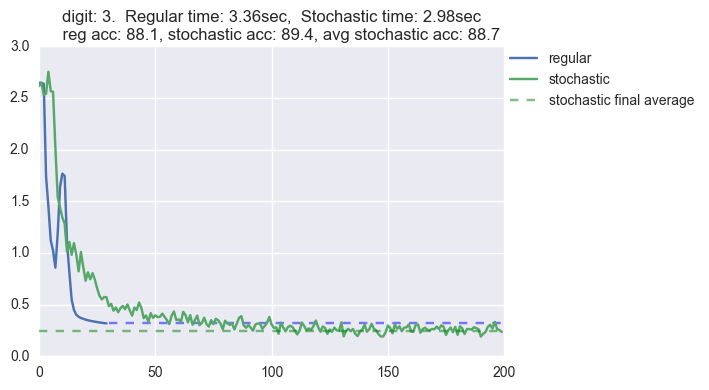

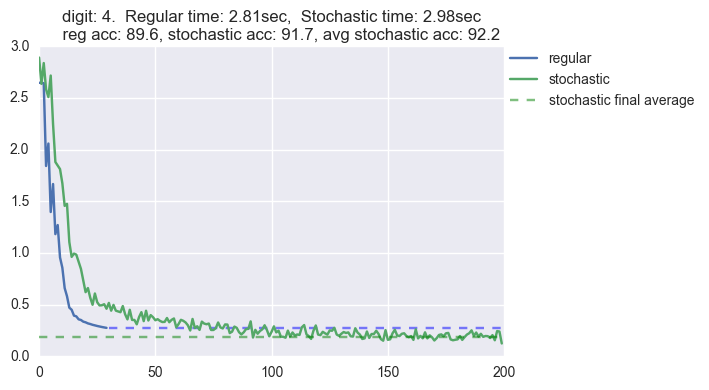

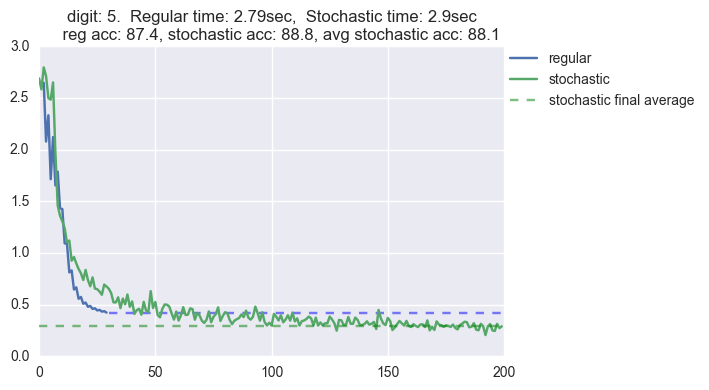

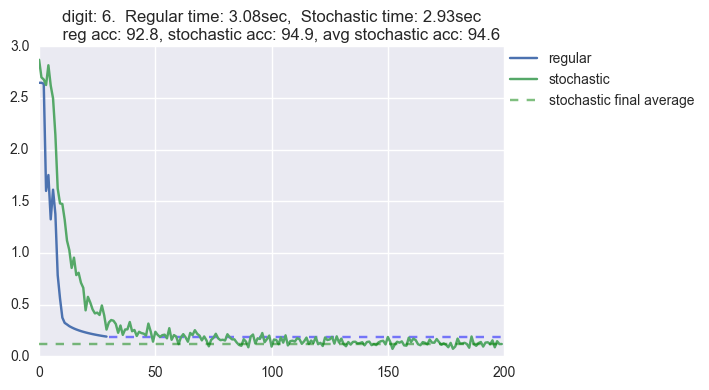

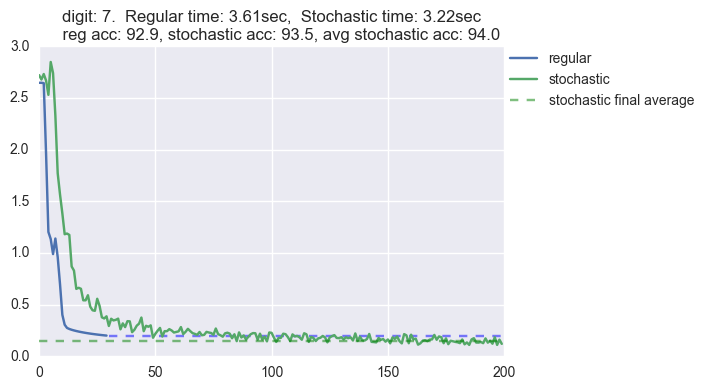

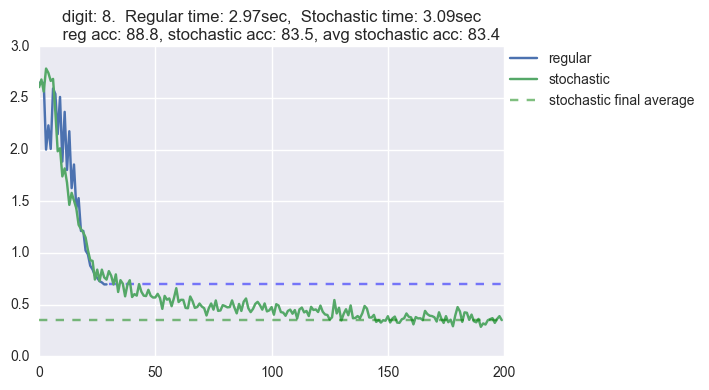

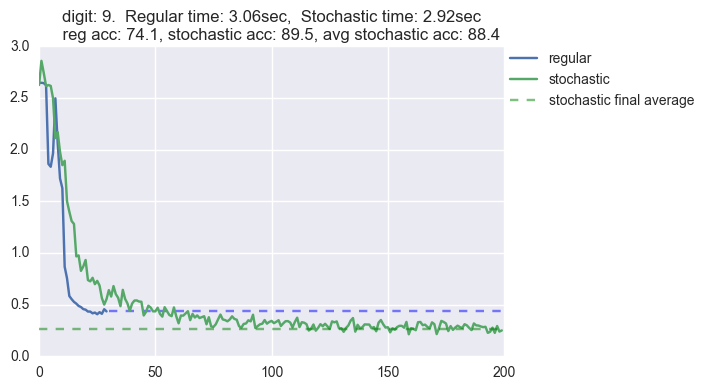

--- 1.207277238368988 minutes ---


In [29]:
start_time = time.time()

dfCVR=pd.DataFrame(index=cvIndex) #dataframe to record each 1-vs-all test in reg version
dfCVR['label']=df2.loc[cvIndex,'label']
dfCVS=pd.DataFrame(index=cvIndex) #dataframe to record each 1-vs-all test in stochastic version
dfCVS['label']=df2.loc[cvIndex,'label']
for x in [0,1,2,3,4,5,6,7,8,9]: #the digits I will be looking to identify from the training data.
    
    #this section resets the label I will you to tell if the number in the training set is or is not the one I want.
    df2['binary']=0;
    df2.loc[df2.loc[:,'label']==x,'binary']=1;
    
    #this section undersamples from the 'not number' part of training set,
    #such that I have an equal number of cases for my code to distiguish between.
    dfTrain=df2.loc[trainIndex,:].copy();
    PosIndex=dfTrain.loc[dfTrain.loc[:,'binary']==1,:].index.values;
    NegIndex=np.random.choice(dfTrain.loc[dfTrain.loc[:,'binary']==0,:].index.values,len(PosIndex),replace=False);
    dfTrainEven=dfTrain.loc[np.concatenate((PosIndex,NegIndex)),:].copy();
    dfTrainEven.loc[:,'binary'].value_counts();
    evenIndex=dfTrainEven.index.values;
    
    #number of steps of gradient descent
    nR=30;
    
    #simple gradient descent
    start_timeR = time.time();
    Theta=np.random.rand(len(df2.iloc[1,2:]));
    X=df2.iloc[evenIndex,2:].values;
    y=df2.iloc[evenIndex,1].values;
    alpha=.0001
    CF=[];
    for i in range(0,nR):
        CF.append(CostFunction(y,Theta,X));
        Theta=GradDescent(y,Theta,X,alpha)
    R_time=np.round((time.time() - start_timeR),2);
    
    #stochastic gradient descent
    nS=200;
    start_timeS = time.time();
    ThetaS=np.random.rand(len(df2.iloc[1,2:]));
    alpha=.0005
    CFS=[];
    ThetaSLastSet=[]; #where I'll store the last 10 values of Theta, to average later
    for i in range(0,nS):
        StochasticIndex=np.random.choice(evenIndex,500,replace=False);
        X=df2.iloc[StochasticIndex,2:].values;
        y=df2.iloc[StochasticIndex,1].values;
        CFS.append(CostFunction(y,ThetaS,X));
        ThetaS=GradDescent(y,ThetaS,X,alpha)
        if i >=n-25:
            ThetaSLastSet.append(ThetaS)
    ThetaSAvg=np.sum(ThetaSLastSet,axis=0)/np.shape(ThetaSLastSet)[0] #average for final stochastic Thetas
    S_time=np.round((time.time() - start_timeS),2);
    
    #using a cross-validation set to check accuracy 
    cvX=df2.iloc[cvIndex,2:].values;
    cvy=df2.iloc[cvIndex,1].values;
    
    acc=np.round(np.sum((sigmoid(Theta,cvX)>.5)==(cvy==1))/len(cvy),3)*100; #reg GS
    accS=np.round(np.sum((sigmoid(ThetaS,cvX)>.5)==(cvy==1))/len(cvy),3)*100; #final Theta of Stochastic GS
    accSAvg=np.round(np.sum((sigmoid(ThetaSAvg,cvX)>.5)==(cvy==1))/len(cvy),3)*100; #avg of final Thetas of SGS
    dfCVR['cv%s'%(x)]=sigmoid(Theta,cvX) #append results to dfCV for future analysis.
    dfCVS['cv%s'%(x)]=sigmoid(ThetaSAvg,cvX) #append results to dfCV for future analysis.
    
    X=df2.iloc[evenIndex,2:].values;
    y=df2.iloc[evenIndex,1].values;
    plt.plot(np.arange(0,len(CF)),CF,label='regular');
    plt.axhline(CF[-1],xmin=nR/nS,color='b',ls='--',alpha=.5)
    plt.plot(np.arange(0,len(CFS)),CFS,label='stochastic');
    plt.axhline(CostFunction(y,ThetaSAvg,X),color='g',ls='--',alpha=.5,label='stochastic final average')
    plt.title("""digit: %s.  Regular time: %ssec,  Stochastic time: %ssec
    reg acc: %s, stochastic acc: %s, avg stochastic acc: %s""" %(x,R_time,S_time,acc,accS,accSAvg))
    plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.)
    plt.show();
print("--- %s minutes ---" % ((time.time() - start_time)/60))

In [32]:
dfCV2=dfCVR.copy()
dfCV2.iloc[:,1:]=dfCV2.div(dfCV2.iloc[:,1:].max(axis=1),axis=0)
dfCV2[dfCV2.iloc[:,1:]<1]=0
for x in range(0,10):
    dfCV2.loc[dfCV2.loc[:,'cv%s'%(x)]>0,'cv%s'%(x)]=x;
dfCV2['Predict']=dfCV2.iloc[:,1:].sum(axis=1);
A=len(dfCV2[dfCV2['label']==dfCV2['Predict']])/len(dfCV2)
print('regular gradient descent accuracy: %s'%(A))

regular gradient descent accuracy: 0.8113095238095238


In [34]:
dfCV2=dfCVS.copy()
dfCV2.iloc[:,1:]=dfCV2.div(dfCV2.iloc[:,1:].max(axis=1),axis=0)
dfCV2[dfCV2.iloc[:,1:]<1]=0
for x in range(0,10):
    dfCV2.loc[dfCV2.loc[:,'cv%s'%(x)]>0,'cv%s'%(x)]=x;
dfCV2['Predict']=dfCV2.iloc[:,1:].sum(axis=1);
A=len(dfCV2[dfCV2['label']==dfCV2['Predict']])/len(dfCV2)
print('stochastic gradient descent accuracy: %s'%(A))

stochastic gradient descent accuracy: 0.8616666666666667
